In [1]:
# load mnist dataset
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn

mnist_train = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

X_train = mnist_train.data
X_test = mnist_test.data
y_train = mnist_train.targets
y_test = mnist_test.targets

print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")


X_train.shape: torch.Size([60000, 28, 28])
X_test.shape: torch.Size([10000, 28, 28])
y_train.shape: torch.Size([60000])
y_test.shape: torch.Size([10000])


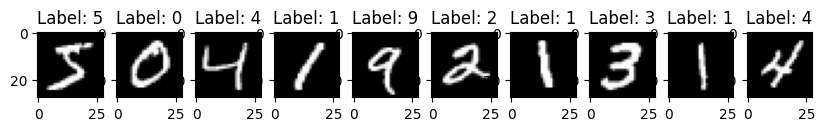

In [2]:
X_train[0].shape

fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    axes[i].imshow(X_train[i].numpy().reshape(28, 28), cmap="gray")
    axes[i].set_title(f"Label: {y_train[i]}")
plt.show()



In [3]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# Flatten the data
X_train = X_train.view(X_train.size(0), -1)
print(f"X_train.shape: {X_train.shape}")
X_test = X_test.view(X_test.size(0), -1)
print(f"X_test.shape: {X_test.shape}")
X_valid = X_valid.view(X_valid.size(0), -1)
print(f"X_valid.shape: {X_valid.shape}")


X_train.shape: torch.Size([55000, 784])
X_test.shape: torch.Size([10000, 784])
X_valid.shape: torch.Size([5000, 784])


7


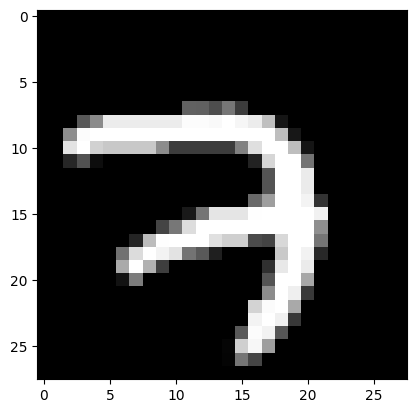

In [4]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

print(class_names[y_train[0]])
plt.imshow(X_train[0].numpy().reshape(28, 28), cmap="gray")
plt.show()


In [5]:
# Define the model
class MNIST_Logistic(nn.Module):
	def __init__(self):
		super().__init__()
		self.fc1 = nn.Linear(784, 300) # input layer
		self.relu = nn.ReLU() # activation function
		self.fc2 = nn.Linear(300, 100) # hidden layer
		self.relu2 = nn.ReLU() # activation function
		self.fc3 = nn.Linear(100, 10) # output layer
		self.softmax = nn.Softmax(dim=1) # softmax function

	def forward(self, x):
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.relu2(x)
		x = self.fc3(x)
		# No softmax - CrossEntropyLoss handles it
		return x

model = MNIST_Logistic()
print(model)

print("-"*40)
print("Model Parameters:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total: {total_params:,} | Trainable: {trainable_params:,}")
print(
	f"{
		(784 + 1) * 300 +
		(300 + 1) * 100 +
		(100 + 1) * 10
	:,}"
)

MNIST_Logistic(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
----------------------------------------
Model Parameters:
Total: 266,610 | Trainable: 266,610
266,610


In [6]:
# Sparse Categorical Cross-Entropy for MNIST
# CrossEntropyLoss expects: logits (no softmax!) + integer labels

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Training loop
epochs = 30
batch_size = 32

# History for plotting
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(epochs):
    # Shuffle each epoch
    perm = torch.randperm(X_train.size(0))
    epoch_loss = 0
    epoch_correct = 0
    n_batches = 0
    
    for i in range(0, X_train.size(0), batch_size):
        idx = perm[i:i+batch_size]
        X_batch, y_batch = X_train[idx], y_train[idx]
        
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_correct += (logits.argmax(dim=1) == y_batch).sum().item()
        n_batches += 1
    
    # Calculate epoch metrics
    avg_loss = epoch_loss / n_batches
    avg_acc = epoch_correct / X_train.size(0)
    
    # Validation
    with torch.no_grad():
        val_logits = model(X_valid)
        val_loss = loss_fn(val_logits, y_valid).item()
        val_acc = (val_logits.argmax(dim=1) == y_valid).float().mean().item()
    
    # Store history
    history['loss'].append(avg_loss)
    history['acc'].append(avg_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={avg_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")


Epoch 1: loss=0.3743, acc=0.8888, val_loss=0.1591, val_acc=0.9526
Epoch 2: loss=0.1294, acc=0.9610, val_loss=0.1160, val_acc=0.9644
Epoch 3: loss=0.0849, acc=0.9737, val_loss=0.0819, val_acc=0.9760
Epoch 4: loss=0.0623, acc=0.9810, val_loss=0.0743, val_acc=0.9784
Epoch 5: loss=0.0480, acc=0.9848, val_loss=0.0742, val_acc=0.9792
Epoch 6: loss=0.0374, acc=0.9885, val_loss=0.0642, val_acc=0.9822
Epoch 7: loss=0.0288, acc=0.9909, val_loss=0.0702, val_acc=0.9820
Epoch 8: loss=0.0210, acc=0.9939, val_loss=0.0638, val_acc=0.9822
Epoch 9: loss=0.0153, acc=0.9960, val_loss=0.0655, val_acc=0.9824
Epoch 10: loss=0.0113, acc=0.9971, val_loss=0.0727, val_acc=0.9812
Epoch 11: loss=0.0076, acc=0.9983, val_loss=0.0705, val_acc=0.9830
Epoch 12: loss=0.0057, acc=0.9989, val_loss=0.0704, val_acc=0.9830
Epoch 13: loss=0.0043, acc=0.9992, val_loss=0.0684, val_acc=0.9832
Epoch 14: loss=0.0027, acc=0.9997, val_loss=0.0707, val_acc=0.9832
Epoch 15: loss=0.0019, acc=0.9998, val_loss=0.0711, val_acc=0.9844
Epoc

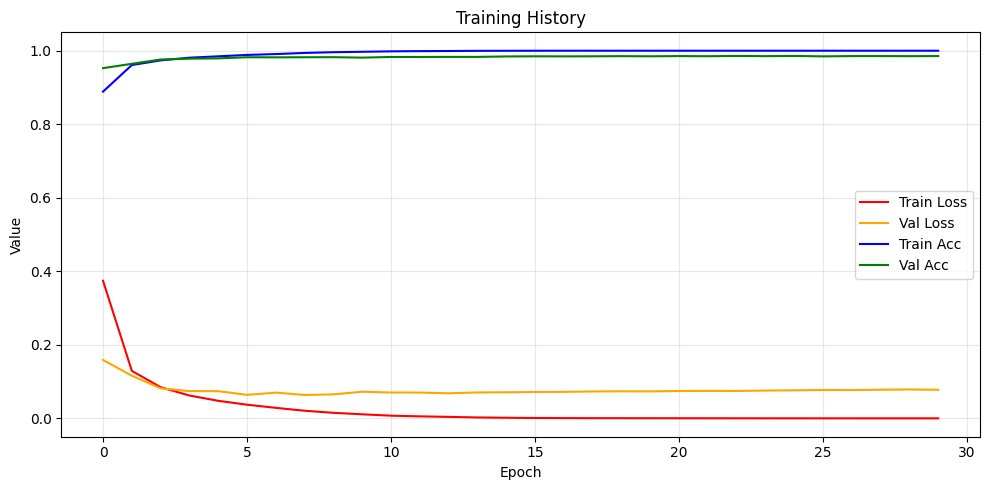

In [8]:
# Plot training history - single scale, different colors
plt.figure(figsize=(10, 5))

plt.plot(history['loss'], color='red', label='Train Loss')
plt.plot(history['val_loss'], color='orange', label='Val Loss')
plt.plot(history['acc'], color='blue', label='Train Acc')
plt.plot(history['val_acc'], color='green', label='Val Acc')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
with torch.no_grad():
	test_logits = model(X_test)
	test_preds = test_logits.argmax(dim=1)
	print(test_preds)

# Test accuracy
test_acc = (test_preds == y_test).float().mean()
print(f"Test Accuracy: {test_acc:.4f}")

tensor([7, 2, 1,  ..., 4, 5, 6])
Test Accuracy: 0.9826


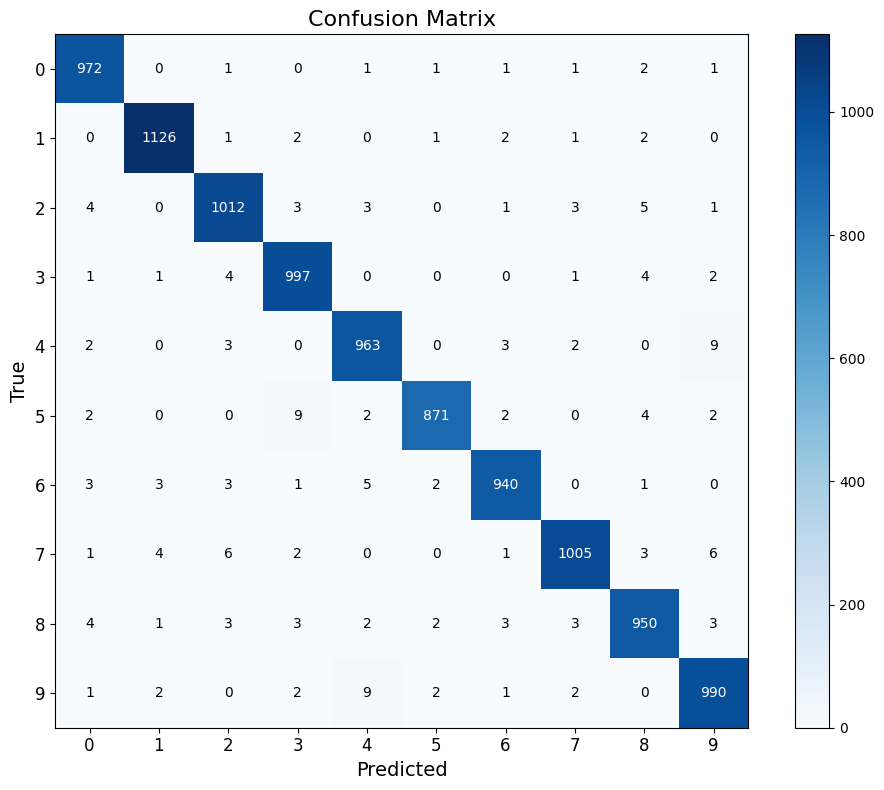

In [20]:
# Build confusion matrix
cm = torch.zeros(10, 10, dtype=torch.int32)
for pred, true in zip(test_preds, y_test):
    cm[true, pred] += 1

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm.numpy(), cmap='Blues')
plt.colorbar(im)

# Add value annotations in each cell
for i in range(10):
    for j in range(10):
        val = cm[i, j].item()
        color = 'white' if val > cm.max() / 2 else 'black'
        ax.text(j, i, str(val), ha='center', va='center', color=color, fontsize=10)

# Labels
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(class_names, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()
